# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [302]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
import operator
from sklearn.preprocessing import LabelEncoder
import re

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [303]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') #load original data set for comparison later

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info_orig = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [304]:
# Load data dictionary file
data_dict = open('Data_Dictionary.md').read()

In [305]:
# Examine the data throughfully
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [306]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows)
print ("Dataset has {} rows, {} columns".format(*azdias.shape))
azdias.head(5)

Dataset has 891221 rows, 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [307]:
feat_info.set_index("attribute", inplace=True) # set attribute as index for future usage
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [308]:
# Identify missing or unknown data values and convert them to NaNs.

In [309]:
# Create a missing data function for better structure.

def missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values
    '''
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    
    return pd.concat([total, percent], axis=1, keys=['total', 'percent'])

In [310]:
missing_data(azdias).head(10)

,total,percent
KK_KUNDENTYP,584612,65.596749
KBA05_ANTG1,133324,14.959701
KBA05_ANTG2,133324,14.959701
KBA05_ANTG3,133324,14.959701
KBA05_ANTG4,133324,14.959701
KBA05_BAUMAX,133324,14.959701
KBA05_GBZ,133324,14.959701
MOBI_REGIO,133324,14.959701
REGIOTYP,121196,13.598872
KKK,121196,13.598872


In [311]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [312]:
# function that converts string encoding missing values into list with numerical values (X, XX -> -1)
def miss_str_to_list(miss_unknown_str):
    '''
    INPUT: single string encoding missing and unknown values
    OUTPUT: list containing all encodings as separate entries
    '''
    # split up total string
    test_list = list(miss_unknown_str)
    
    missing_values=[]
    
    # save all relevant entries of list 
    for kk in range(0,len(test_list)):
        if test_list[kk] not in ['[',']',',']:
            missing_values.append(test_list[kk])    
    
    # combine '-' and '1' into '-1' and 'X' 'X' into 'XX'
    missing_values2=[] 
    counter=0 
    while counter < len(missing_values):
        if missing_values[counter]=='-':
            missing_values2.append(missing_values[counter]+missing_values[counter+1])
            counter+=2
        elif missing_values[counter]=='X' and counter <(len(missing_values)-1):
            if missing_values[counter+1]=='X':
                missing_values2.append(missing_values[counter]+missing_values[counter+1])
                counter+=2
            else:
                missing_values2.append(missing_values[counter])
                counter+=1
        else:
            missing_values2.append(missing_values[counter])
            counter+=1
    
    # replace str by int if possible
    for ii in range(0,len(missing_values2)):
        if missing_values2[ii] in ['-1', '0', '9']:
            missing_values2[ii]=int(missing_values2[ii])
           
    return missing_values2

In [313]:
# Step to identify missing or unknown data values and convert them to NaNs.
for key in azdias.keys():
    # get string encoding from feat_info
    miss_unknown_str = feat_info.loc[key].missing_or_unknown
    # convert string into list
    missing_unknown_values = miss_str_to_list(miss_unknown_str)
    # replace with NaN
    if len(missing_unknown_values)>0:
        azdias[key].replace(missing_unknown_values, np.nan, inplace=True)

In [314]:
missing_data(azdias).head(10)

,total,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


In [315]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [316]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

In [317]:
def cols_with_missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: keys of columns with missing data
    '''
    #search for columns with missing data values
    cols_with_missing = [col for col in data.columns 
                                 if data[col].isnull().any()]
    return cols_with_missing

In [318]:
cols_with_missing = cols_with_missing_data(azdias_orig)
print(cols_with_missing)
print('Number of columns with missing data values: ', len(cols_with_missing))

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
Number of columns with missing data values:  53


In [319]:
missing_data(azdias)

,total,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


In [320]:
missing_value_per_feature = missing_data(azdias)

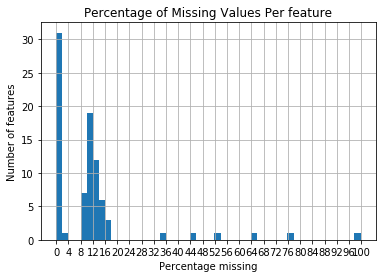

In [321]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_value_per_feature['percent'],bins=50)
plt.title("Percentage of Missing Values Per feature");
plt.ylabel("Number of features");
plt.xlabel("Percentage missing");
plt.xticks(np.arange(0, 101, step=4))
plt.grid()

In [322]:
# detect features where large fraction of values are missing

# from the above diagram, 18% or 20% is a possible threshold to distinguish the features with large missing values

nan_threshold = 0.18
outliers = [key for key in azdias.keys() if azdias[key].isnull().sum()/len(azdias[key]) > nan_threshold]
print(outliers)
print(len(outliers))

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
6


In [323]:
# Remove the outlier columns from the dataset.

azdias_drop = azdias.drop(outliers, axis=1)
print('Shape of original data set: ', azdias.shape)
print('Shape of data set w/o outlier columns: ', azdias_drop.shape)

Shape of original data set:  (891221, 85)
Shape of data set w/o outlier columns:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The column with more than 18% missing values were considered outlier and so they were dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [324]:
# How much data is missing in each row of the dataset?

In [325]:
def missing_data_rows(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values per row
    '''
    
    missing_values_row_abs = data.isnull().sum(axis=1)
    missing_values_row_percent = (data.isnull().sum(axis=1)/data.shape[1])*100
    missing_values_row = pd.concat([missing_values_row_abs, missing_values_row_percent], axis=1, keys=['total', 'percent'])
    
    return missing_values_row

In [326]:
missing_values_row = missing_data_rows(azdias)

In [327]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [328]:
nan_threshold_percent = 20
missing_values_row['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]

In [329]:
low0 = missing_values_row.loc[missing_values_row.subset==0]

In [330]:
print('Number in subset with large number of missing values: ', missing_values_row['subset'].sum())
print('Percent in subset with large number of missing values: ', (missing_values_row['subset'].sum()/len(missing_values_row['subset']))*100)

Number in subset with large number of missing values:  107876
Percent in subset with large number of missing values:  12.1042928746


In [331]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_plot(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''
    use it to compare the distribution between subset 1 and subset 0
    '''
    
    s0 = data.loc[data.subset==0, col].value_counts()
    s1 = data.loc[data.subset==1, col].value_counts()
    
    plt.figure(figsize = size)
    
    plt.subplot(1,2,1)
    sns.barplot(x = s0.index, y=s0.values)
    plt.title('subgroup 0: Few NaNs')
    plt.xticks(rotation=xlabel_angle)
    
    plt.subplot(1,2,2)
    sns.barplot(x = s1.index, y=s1.values)
    plt.title('subgroup 1: Many NaNs')
    plt.xticks(rotation=xlabel_angle)
    plt.show()

In [332]:
azdias['subset'] = missing_values_row['subset']

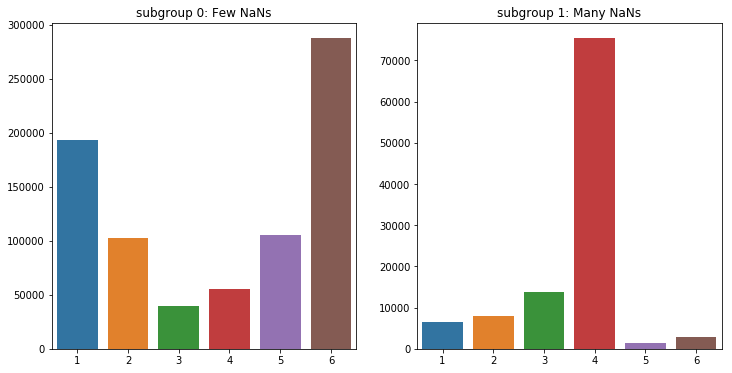

In [333]:
compare_plot(azdias,'FINANZTYP')

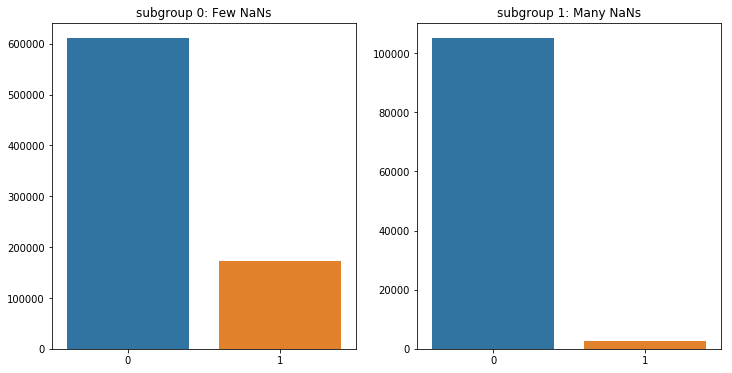

In [334]:
compare_plot(azdias,'GREEN_AVANTGARDE')

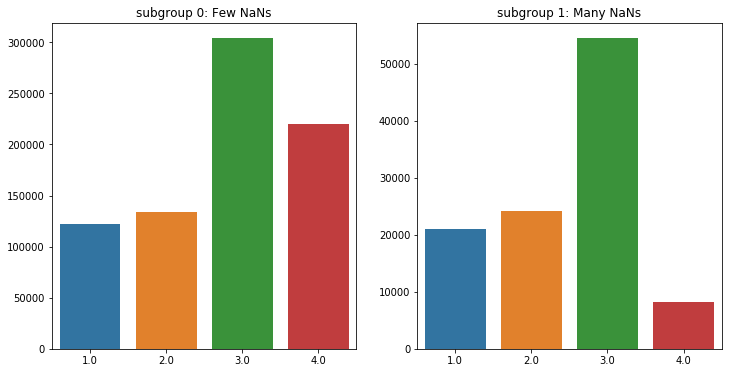

In [335]:
compare_plot(azdias,'ALTERSKATEGORIE_GROB')

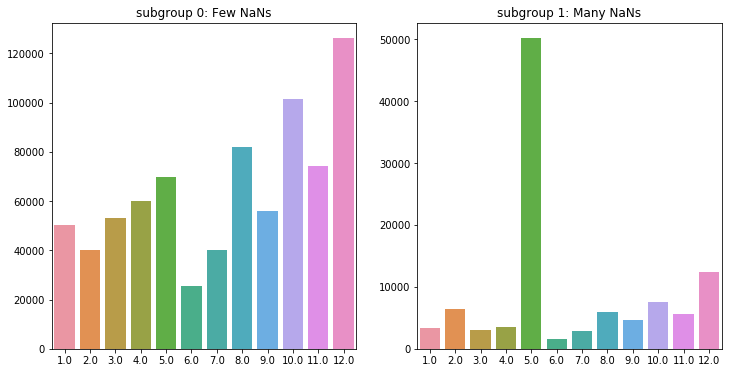

In [336]:
compare_plot(azdias,'GFK_URLAUBERTYP')

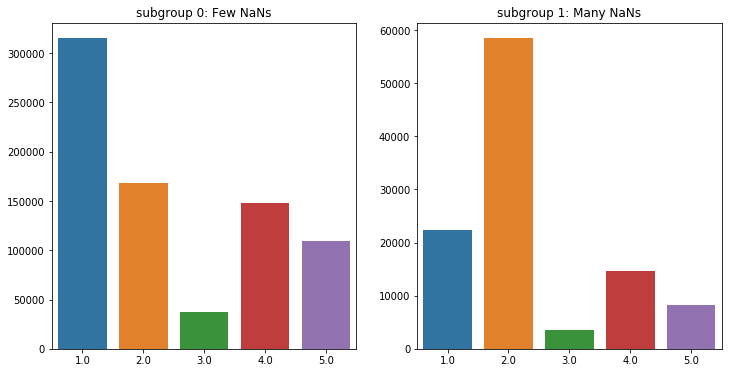

In [337]:
compare_plot(azdias,'LP_STATUS_GROB')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Threshold = 20 (number of feature missing for one row), divided data into 2 groups.

The data with many missing values looks very different from the data with few or no missing values. 

There are obvious qualitative differences. 

Dropping those points from the analysis shoud present a major issue, because we lose information.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [338]:
# How many features are there of each data type?

feat_info_orig['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [339]:
number_features_categorical=(feat_info_orig['type']=='categorical').sum()
number_features_ordinal=(feat_info_orig['type']=='ordinal').sum()
number_features_mixed=(feat_info_orig['type']=='mixed').sum()
number_features_numeric=(feat_info_orig['type']=='numeric').sum()
number_features_interval=(feat_info_orig['type']=='interval').sum()
# check if sum of all features adds up to 85
number_features_total = (number_features_categorical + number_features_ordinal 
                         + number_features_mixed + number_features_numeric + number_features_interval)

In [340]:
print('Number of numeric features: ', number_features_numeric)
print('Number of ordinal features: ', number_features_ordinal)
print('Number of categorical features: ', number_features_categorical)
print('Number of mixed features: ', number_features_mixed)
print('Number of interval features: ', number_features_interval)
print('Number of all features: ', number_features_total)

Number of numeric features:  7
Number of ordinal features:  49
Number of categorical features:  21
Number of mixed features:  7
Number of interval features:  1
Number of all features:  85


In [341]:
features_categorical = list(feat_info_orig[feat_info_orig.type=='categorical'].attribute)
features_ordinal = list(feat_info_orig[feat_info_orig.type=='ordinal'].attribute)
features_mixed = list(feat_info_orig[feat_info_orig.type=='mixed'].attribute)
features_numeric = list(feat_info_orig[feat_info_orig.type=='numeric'].attribute)
features_interval = list(feat_info_orig[feat_info_orig.type=='interval'].attribute)

In [342]:
print('Mixed features: ', features_mixed)
print(len(features_mixed))

Mixed features:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
7


In [343]:
print('Categorical features: ', features_categorical)
print(len(features_categorical))

Categorical features:  ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
21


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [344]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_variables = feat_info[feat_info['type'] == 'categorical']
categorical_variables

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZTYP,person,categorical,[-1]
GFK_URLAUBERTYP,person,categorical,[]
GREEN_AVANTGARDE,person,categorical,[]
LP_FAMILIE_FEIN,person,categorical,[0]
LP_FAMILIE_GROB,person,categorical,[0]
LP_STATUS_FEIN,person,categorical,[0]


In [345]:
features_categorical_drop_binary = []
features_categorical_drop_multilevel = []

for key in features_categorical:
    if key in azdias_drop.keys():
        if len(azdias_drop[key].dropna().unique())==2:
            features_categorical_drop_binary.append(key)   
        else:
            features_categorical_drop_multilevel.append(key)

print('Catgorical (binary) features:\n', features_categorical_drop_binary)   
print('Number of categorical (binary) features: ', len(features_categorical_drop_binary))   

print('Catgorical (multi-level) features:\n', features_categorical_drop_multilevel)
print('Number of categorical (multi-level) features: ', len(features_categorical_drop_multilevel))

Catgorical (binary) features:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Number of categorical (binary) features:  5
Catgorical (multi-level) features:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Number of categorical (multi-level) features:  13


In [346]:
# Binary features: encoding
for key in features_categorical_drop_binary:
    print(key, azdias_drop[key].dropna().unique())

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [ 2.  1.]
OST_WEST_KZ ['W' 'O']


In [347]:
# NOTE: the feature OST_WEST_KZ takes on non-numeric values and needs to be recoded
azdias_drop['OST_WEST_KZ'].head()

0    NaN
1      W
2      W
3      W
4      W
Name: OST_WEST_KZ, dtype: object

In [348]:
azdias_drop['OST_WEST_KZ'].replace('W', 0, inplace=True)
azdias_drop['OST_WEST_KZ'].replace('O', 1, inplace=True)
azdias_drop['OST_WEST_KZ'].head()

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: OST_WEST_KZ, dtype: float64

In [349]:
azdias_drop['OST_WEST_KZ'].unique()

array([ nan,   0.,   1.])

In [350]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [351]:
for key in features_categorical_drop_multilevel:
    print(key, azdias_drop[key].dropna().unique())

CJT_GESAMTTYP [ 2.  5.  3.  4.  1.  6.]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.]
LP_FAMILIE_FEIN [  2.   5.   1.  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB [ 2.  3.  1.  5.  4.]
LP_STATUS_FEIN [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.]
LP_STATUS_GROB [ 1.  2.  4.  5.  3.]
NATIONALITAET_KZ [ 1.  3.  2.]
SHOPPER_TYP [ 3.  2.  1.  0.]
ZABEOTYP [3 5 4 1 6 2]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C' '7D'
 '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [352]:
# For simplicity, we keep the binary categorical features (with all of them transformed to numeric values) 
# and we drop the categorical multilevel features.

In [353]:
# Dropping the multi level categorical variables

azdias_drop = azdias_drop.drop(features_categorical_drop_multilevel, axis=1)

In [354]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

I dropped the multi level categorical variables and re-encoded all the other binary categorical variables(both numeric and non numeric)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [355]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [356]:
print('Mixed features: \n', features_mixed)

Mixed features: 
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [357]:
# Drop other features except for 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'.

import copy
features_mixed_dropped = copy.deepcopy(features_mixed)
features_mixed_dropped.remove('PRAEGENDE_JUGENDJAHRE')
features_mixed_dropped.remove('CAMEO_INTL_2015')
print('Mixed features (to be dropped): \n', features_mixed_dropped)

Mixed features (to be dropped): 
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [358]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(np.sort(azdias_drop['PRAEGENDE_JUGENDJAHRE'].unique()))

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  nan]


# check data_dict

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [359]:
# PJ: movement
mainstream = [1, 3, 5, 8, 10, 12, 14]
avant = [2, 4, 6, 7, 9, 11, 13, 15]

In [360]:
conditions = [
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
azdias_drop['PJ_move'] = np.select(conditions, choices, default=np.nan)

In [361]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_move']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_move
0,NaN,NaN
1,14.0,0.0
2,15.0,1.0
3,8.0,0.0
4,8.0,0.0


In [362]:
# PJ: decade
decade1 = [1, 2]
decade2 = [3, 4]
decade3 = [5, 6, 7]
decade4 = [8, 9]
decade4 = [10, 11, 12, 13]
decade5 = [14, 15]

In [363]:
conditions = [
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
azdias_drop['PJ_decade'] = np.select(conditions, choices, default=np.nan)

In [364]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_decade']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_decade
0,NaN,NaN
1,14.0,5.0
2,15.0,5.0
3,8.0,3.0
4,8.0,3.0


In [365]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_move', 'PJ_decade']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_move,PJ_decade
0,NaN,NaN,NaN
1,14.0,0.0,5.0
2,15.0,1.0,5.0
3,8.0,0.0,3.0
4,8.0,0.0,3.0


In [366]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

print('Unique values of CAMEO_INTL_2015: \n', azdias_drop['CAMEO_INTL_2015'].unique())
print('Number of unique values: ', len(azdias_drop['CAMEO_INTL_2015'].unique()))

Unique values of CAMEO_INTL_2015: 
 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
Number of unique values:  22


# check data_dict

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [367]:
conditions = [
    (azdias_drop['CAMEO_INTL_2015'] == '51'),
    (azdias_drop['CAMEO_INTL_2015'] == '24'),
    (azdias_drop['CAMEO_INTL_2015'] == '12'),
    (azdias_drop['CAMEO_INTL_2015'] == '43'),
    (azdias_drop['CAMEO_INTL_2015'] == '54'),
    (azdias_drop['CAMEO_INTL_2015'] == '22'),
    (azdias_drop['CAMEO_INTL_2015'] == '14'),
    (azdias_drop['CAMEO_INTL_2015'] == '13'),
    (azdias_drop['CAMEO_INTL_2015'] == '15'),
    (azdias_drop['CAMEO_INTL_2015'] == '33'),
    (azdias_drop['CAMEO_INTL_2015'] == '41'),
    (azdias_drop['CAMEO_INTL_2015'] == '34'),
    (azdias_drop['CAMEO_INTL_2015'] == '55'),
    (azdias_drop['CAMEO_INTL_2015'] == '25'),
    (azdias_drop['CAMEO_INTL_2015'] == '23'),
    (azdias_drop['CAMEO_INTL_2015'] == '31'),
    (azdias_drop['CAMEO_INTL_2015'] == '52'),
    (azdias_drop['CAMEO_INTL_2015'] == '35'),
    (azdias_drop['CAMEO_INTL_2015'] == '45'),
    (azdias_drop['CAMEO_INTL_2015'] == '44'),
    (azdias_drop['CAMEO_INTL_2015'] == '32')]
choices = [5, 2, 1, 4, 5, 2, 1, 1, 1, 3, 4, 3, 5, 2, 2, 3, 5, 3, 4, 4, 3]
azdias_drop['CAMEO_INTL_2015_first'] = np.select(conditions, choices, default=np.nan)

In [368]:
conditions = [
    (azdias_drop['CAMEO_INTL_2015'] == '51'),
    (azdias_drop['CAMEO_INTL_2015'] == '24'),
    (azdias_drop['CAMEO_INTL_2015'] == '12'),
    (azdias_drop['CAMEO_INTL_2015'] == '43'),
    (azdias_drop['CAMEO_INTL_2015'] == '54'),
    (azdias_drop['CAMEO_INTL_2015'] == '22'),
    (azdias_drop['CAMEO_INTL_2015'] == '14'),
    (azdias_drop['CAMEO_INTL_2015'] == '13'),
    (azdias_drop['CAMEO_INTL_2015'] == '15'),
    (azdias_drop['CAMEO_INTL_2015'] == '33'),
    (azdias_drop['CAMEO_INTL_2015'] == '41'),
    (azdias_drop['CAMEO_INTL_2015'] == '34'),
    (azdias_drop['CAMEO_INTL_2015'] == '55'),
    (azdias_drop['CAMEO_INTL_2015'] == '25'),
    (azdias_drop['CAMEO_INTL_2015'] == '23'),
    (azdias_drop['CAMEO_INTL_2015'] == '31'),
    (azdias_drop['CAMEO_INTL_2015'] == '52'),
    (azdias_drop['CAMEO_INTL_2015'] == '35'),
    (azdias_drop['CAMEO_INTL_2015'] == '45'),
    (azdias_drop['CAMEO_INTL_2015'] == '44'),
    (azdias_drop['CAMEO_INTL_2015'] == '32')]
choices = [1, 4, 2, 3, 4, 2, 4, 3, 5, 3, 1, 4, 5, 5, 3, 1, 2, 5, 5, 4, 2]
azdias_drop['CAMEO_INTL_2015_second'] = np.select(conditions, choices, default=np.nan)

In [369]:
azdias_drop[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_first', 'CAMEO_INTL_2015_second']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_first,CAMEO_INTL_2015_second
0,NaN,NaN,NaN
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0


In [370]:
# drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
azdias_drop = azdias_drop.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

In [371]:
azdias_drop.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 

In [372]:
# drop other mixed features (if not dropped alreday because of excessive number of NaN values)
for key in features_mixed_dropped:
    print(key)
    if key in azdias_drop.keys():
        azdias_drop = azdias_drop.drop(key, axis=1)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
WOHNLAGE
KBA05_BAUMAX
PLZ8_BAUMAX


In [373]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first,CAMEO_INTL_2015_second
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,5.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,3.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

The following steps have been perfomed for mixed-type features:

The feature PRAEGENDE_JUGENDJAHRE has been split up into two new features, namely PJ_move and PJ_decade, as suggested.
The feature CAMEO_INTL_2015 has been split up into two new features, namely CAMEO_INTL_2015_first and CAMEO_INTL_2015_second, as suggested.
The original features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 have been dropped.

To keep things straightforward, all other mixed-type features have been dropped.

(a)LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB summarize (according to the data dictionary) personal age, salary level and houshold type. This information is contained already in other variables such as ALTERSKATEGORIE_GROB and HH_EINKOMMEN_SCORE.

(b)KBA05BAUMAX and PLZ8BAUMAX does not provide essential additional information

(c)WOHNLAGE describes the neighborhood quality, already explained in other feature like HH_EINKOMMEN_SCORE. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [374]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [375]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [376]:
# print outlier columns (excessive number of NaN values) for fixed NaN threshold of 20%
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [377]:
# print mixed-type features to be dropped (see above for detailed explanation)
print(features_mixed_dropped)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [378]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    
    for key in df.keys():
        # get string encoding from feat_info
        miss_unknown_str = feat_info.loc[key].missing_or_unknown
        # convert string into list
        missing_unknown_values = miss_str_to_list(miss_unknown_str)
        # replace with NaN
        if len(missing_unknown_values)>0:
            df[key].replace(missing_unknown_values, np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    
    # remove outlier columns: 
    # take outliers as identified above from original azdias dataset such that both 
    # the general population and customer data have the same columns
    df_drop = df.drop(outliers, axis=1)

    # remove outlier rows: 
    # missing_values_row_percent = (df.isnull().sum(axis=1)/df.shape[1])*100
    missing_values_row = missing_data_rows(df_drop)
    nan_threshold_percent = 20
    
    df_drop['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    df_drop_drop = df_drop.loc[df_drop.subset==0]
    df_drop_drop = df_drop[df_drop.subset==0]
    df_drop_drop = df_drop_drop.drop('subset', axis=1)
    
    # select, re-encode, and engineer column values.

    # re-encode binary
    df_drop_drop['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df_drop_drop['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    # drop categorical multilevel
    df_drop_drop = df_drop_drop.drop(features_categorical_drop_multilevel, axis=1)
    
    # MIXED-type features
    # engineer new features out of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    conditions = [
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    df_drop_drop['PJ_move'] = np.select(conditions, choices, default=np.nan)
    
    conditions = [
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
    df_drop_drop['PJ_decade'] = np.select(conditions, choices, default=np.nan)
    
    df_drop_drop['CAMEO_INTL_2015'].replace(np.nan, '99', inplace=True)
    # convert to numeric values
    df_drop_drop['CAMEO_INTL_2015_first_auto'] = pd.to_numeric(df_drop_drop['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_drop_drop['CAMEO_INTL_2015_first_auto'] = np.floor(df_drop_drop['CAMEO_INTL_2015_first_auto']/10)
    # convert to numeric values
    df_drop_drop['CAMEO_INTL_2015_second_auto'] = pd.to_numeric(df_drop_drop['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_drop_drop['CAMEO_INTL_2015_second_auto'] = np.mod(df_drop_drop['CAMEO_INTL_2015_second_auto'], 10)
    # convert original NaN values
    df_drop_drop['CAMEO_INTL_2015'].replace('99', np.nan, inplace=True)
    df_drop_drop['CAMEO_INTL_2015_first_auto'].replace(9, np.nan, inplace=True)
    df_drop_drop['CAMEO_INTL_2015_second_auto'].replace(9, np.nan, inplace=True)
    
    # drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df_drop_drop = df_drop_drop.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # drop remaining mixed-type features (if not dropped alreday because of excessive number of NaN values)
    for key in features_mixed_dropped:
        if key in df_drop_drop.keys():
            df_drop_drop = df_drop_drop.drop(key, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_drop_drop

In [379]:
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') #load original data set for comparison later
azdias_drop_drop = clean_data(azdias_orig)

In [380]:
azdias_drop_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,5.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,3.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,1.0,5.0,4.0


In [381]:
azdias_drop_drop.shape

(792287, 64)

In [382]:
azdias_orig.shape

(891221, 85)

In [383]:
for key in outliers:
    print(key in azdias_drop_drop.keys())

False
False
False
False
False
False


In [384]:
for key in features_mixed_dropped:
    print(key in azdias_drop_drop.keys())

False
False
False
False
False


In [385]:
def get_outlier_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame for outlier data with large NAN fraction
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    
    for key in df.keys():
        # get string encoding from feat_info
        miss_unknown_str = feat_info.loc[key].missing_or_unknown
        # convert string into list
        missing_unknown_values = miss_str_to_list(miss_unknown_str)
        # replace with NaN
        if len(missing_unknown_values)>0:
            df[key].replace(missing_unknown_values, np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    
    # remove outlier columns: 
    # take outliers as identified above from original azdias dataset such that both 
    # the general population and customer data have the same columns
    df_drop = df.drop(outliers, axis=1)

    # save outlier rows: 
    missing_values_row = missing_data_rows(df_drop)
    nan_threshold_percent = 20
    
    df_drop['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    # df_drop_drop = df_drop.loc[df_drop.subset==0]
    df_out = df_drop[df_drop.subset==1]
    df_out = df_out.drop('subset', axis=1)
    
    # select, re-encode, and engineer column values.

    # re-encode binary
    df_out['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df_out['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    # drop categorical multilevel
    df_out = df_out.drop(features_categorical_drop_multilevel, axis=1)
    
    # MIXED-type features
    # engineer new features out of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    conditions = [
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    df_out['PJ_move'] = np.select(conditions, choices, default=np.nan)
    
    conditions = [
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
    df_out['PJ_decade'] = np.select(conditions, choices, default=np.nan)
    
    df_out['CAMEO_INTL_2015'].replace(np.nan, '99', inplace=True)
    # convert to numeric values
    df_out['CAMEO_INTL_2015_first_auto'] = pd.to_numeric(df_out['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_out['CAMEO_INTL_2015_first_auto'] = np.floor(df_out['CAMEO_INTL_2015_first_auto']/10)
    # convert to numeric values
    df_out['CAMEO_INTL_2015_second_auto'] = pd.to_numeric(df_out['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_out['CAMEO_INTL_2015_second_auto'] = np.mod(df_out['CAMEO_INTL_2015_second_auto'], 10)
    # convert original NaN values
    df_out['CAMEO_INTL_2015'].replace('99', np.nan, inplace=True)
    df_out['CAMEO_INTL_2015_first_auto'].replace(9, np.nan, inplace=True)
    df_out['CAMEO_INTL_2015_second_auto'].replace(9, np.nan, inplace=True)
    
    # drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df_out = df_out.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # drop remaining mixed-type features (if not dropped alreday because of excessive number of NaN values)
    for key in features_mixed_dropped:
        if key in df_out.keys():
            df_out = df_out.drop(key, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_out

In [386]:
data_out = get_outlier_data(azdias_orig)

In [387]:
print('Shape of original data: ', azdias_orig.shape)
print('Shape of trimmed, clean data (low NaN rows): ', azdias_drop_drop.shape)
print('Shape of trimmed, clean data (high NaN rows: Outliers): ', data_out.shape)

Shape of original data:  (891221, 85)
Shape of trimmed, clean data (low NaN rows):  (792287, 64)
Shape of trimmed, clean data (high NaN rows: Outliers):  (98934, 64)


In [388]:
#check if low-nan dataset and outlier dataset combine together to the full dataset
print('Shape of two data sets correct: ', azdias_orig.shape[0] == (data_out.shape[0]+azdias_drop_drop.shape[0]))

Shape of two data sets correct:  True


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [389]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [390]:
# Apply feature scaling to the general population demographics data.

In [391]:
from sklearn.preprocessing import Imputer, StandardScaler 

def transform_data(data_in, verbose=False):
    """
    cleans up data
    """
        
    # replace nan values with mean
    imputer = Imputer()
    data_out = imputer.fit_transform(data_in)
    
    # scale data using StandardScaler
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)

    data_out = pd.DataFrame(data=data_out,    # values
     index=data_in.index,    # 1st column as index
     columns=data_in.keys())

    return data_out

In [392]:
data_scaled = transform_data(azdias_drop_drop)

In [393]:
data_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,0.418307,1.440698,0.563306,-0.169827,-0.129548,0.682837,-0.553051,1.166699,1.187475,-1.263906
2,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.972746,0.402065,0.563306,-0.169827,-0.129548,-0.791434,1.873450,1.166699,-0.866186,0.761064
3,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.972746,-0.636568,0.563306,-1.174089,-1.000290,-0.054298,-0.553051,-0.229956,-1.550740,-0.588916
4,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,0.418307,-0.636568,-0.346657,0.834436,0.305823,1.419973,-0.553051,-0.229956,0.502921,0.086074
5,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,0.418307,1.440698,1.473269,-1.174089,-1.000290,-0.054298,-0.553051,-1.626612,1.187475,0.761064


In [96]:
# repeat procedure with function that also returns imputer and scaler objects for later use

from sklearn.preprocessing import Imputer, StandardScaler 

def transform_data2(data_in, verbose=False):
    """
    cleans up data and return both imputer and scaler objects
    """
        
    # replace nan values with mean
    imputer = Imputer()
    data_out = imputer.fit_transform(data_in)
    
    # scale data using StandardScaler
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)

    data_out = pd.DataFrame(data=data_out,    # values
     index=data_in.index,    # 1st column as index
     columns=data_in.keys())

    return data_out, imputer, scaler

In [97]:
data_scaled, imputer, scaler = transform_data2(azdias_drop_drop)

In [98]:
data_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,0.418307,1.440698,0.563306,-0.169827,-0.129548,0.682837,-0.553051,1.166699,1.187475,-1.263906
2,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.972746,0.402065,0.563306,-0.169827,-0.129548,-0.791434,1.873450,1.166699,-0.866186,0.761064
3,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.972746,-0.636568,0.563306,-1.174089,-1.000290,-0.054298,-0.553051,-0.229956,-1.550740,-0.588916
4,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,0.418307,-0.636568,-0.346657,0.834436,0.305823,1.419973,-0.553051,-0.229956,0.502921,0.086074
5,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,0.418307,1.440698,1.473269,-1.174089,-1.000290,-0.054298,-0.553051,-1.626612,1.187475,0.761064


In [394]:
# transform outlier data as well 
data_out_imp = imputer.transform(data_out)
data_out_scaled = scaler.transform(data_out_imp)
data_out_scaled = pd.DataFrame(data=data_out_scaled,    # values
     index=data_out.index,    # 1st column as index
     columns=data_out.keys())

In [395]:
data_out_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
11,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
14,0.200742,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
17,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
24,0.200742,0.958103,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16


### Discussion 2.1: Apply Feature Scaling

Decisions regrading feature scaling:

After previously dropping both rows and columns with excessive number of NaN values, I use sklearn Imputer to handle the remainging NaN values, replacing them with the corresponding mean values.
Therafter, the data are scaled using the sklearn StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [396]:
# Apply PCA to the data.

In [412]:
from sklearn.decomposition import PCA

# apply PCA by fitting scaled data with number of dimensions set to number of features
pca = PCA()
X_pca = pca.fit_transform(data_scaled)

In [398]:
# Investigate the variance accounted for by each principal component.

In [414]:
explained_var = pca.explained_variance_ratio_
explained_var2=sum([explained_var[i] for i in range(2)])
explained_var4=sum([explained_var[i] for i in range(4)])
explained_var10=sum([explained_var[i] for i in range(10)])
explained_var20=sum([explained_var[i] for i in range(20)])
print('Total Variance from first 2 components: ', explained_var2)
print('Total Variance from first 4 components: ', explained_var4) 
print('Total Variance from first 10 components: ', explained_var10)
print('Total Variance from first 20 components: ', explained_var20)


Total Variance from first 2 components:  0.3030895273
Total Variance from first 4 components:  0.45050023386
Total Variance from first 10 components:  0.617323993808
Total Variance from first 20 components:  0.78345481921


In [415]:
explained_var_list = []
number_comp=[]
explained_var = pca.explained_variance_ratio_

for cc in range(0, 20):
    exp_var_sum = sum([explained_var[i] for i in range(cc)])
    explained_var_list.append(exp_var_sum)
    number_comp.append(cc)

In [416]:
explained_var_diff_list = []
number_comp_diff=[]

for cc in range(0, len(explained_var_list)-1):
    exp_var_diff = explained_var_list[cc+1]-explained_var_list[cc]
    explained_var_diff_list.append(exp_var_diff)
    number_comp_diff.append(cc)

Text(0,0.5,'total explained variance')

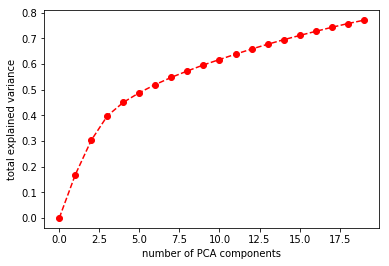

In [417]:
plt.plot(number_comp, explained_var_list,linestyle='--', marker='o', color='r')
plt.xlabel('number of PCA components')
plt.ylabel('total explained variance')

Text(0,0.5,'incremental variance')

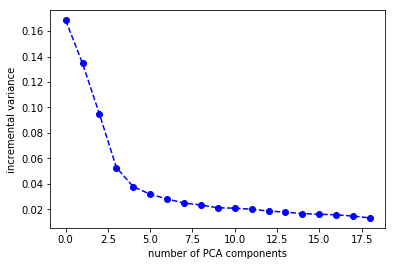

In [418]:
plt.plot(number_comp_diff, explained_var_diff_list, linestyle='--', marker='o', color='b')
plt.xlabel('number of PCA components')
plt.ylabel('incremental variance')
# plt.title('SSE score')

In [419]:
comp=1
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.168533059677


In [420]:
comp=5
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.037681998982


In [421]:
comp=6
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.0317937940671


In [422]:
comp=26
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.00908059881493


The incremental variance (the variance added by adding one more PCA component) flattens out between 5-6 PCA components, with an added variance of about 3%.

Starting from 26 PCA components, the added variance is below 1%.

In [408]:
explained_var=sum([explained_var[i] for i in range(26)])
print('Total Variance from first 26 components: ', explained_var)

Total Variance from first 26 components:  0.850531101062


In [409]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

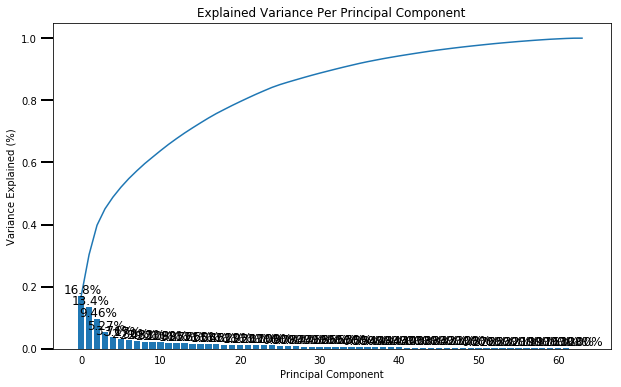

In [410]:
scree_plot(pca)

In [423]:
explained_var40=sum([explained_var[i] for i in range(40)])
print('Total Variance from first 40 components: ', explained_var40)

Total Variance from first 40 components:  0.938543953619


In [424]:
# Re-apply PCA to the data while selecting for number of components to retain.

In [425]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    # X = StandardScaler().fit_transform(data)
    X = data
    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [426]:
# PCA with n_components=40
pca, X_pca = do_pca(40, data_scaled)

In [453]:
# apply the same pca transform to the outlier data (no fit)
X_out_pca = pca.transform(data_out_scaled)

In [428]:
X_pca.shape

(792287, 40)

In [429]:
X_out_pca.shape

(98934, 40)

In [430]:
# PCA with n_components=26 (second run)
pca26, X_pca26 = do_pca(26, data_scaled)

In [431]:
# apply the same pca transform to the outlier data (no fit)
X_out_pca26 = pca.transform(data_out_scaled)

In [432]:
X_pca26.shape

(792287, 26)

In [433]:
X_out_pca26.shape

(98934, 40)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the scree plot shown above, I have done one analysis with 40 components which explains more than 90% of the variance.

In a second run, I have investigated the incremental varaince explained by adding one more principal component. Here, one can make the following observations: (i) The incremental variance (the variance added by adding one more PCA component) flattens out between 5-6 PCA components, with an added variance of about 3%. (ii) Starting from 26 PCA components, the added variance is below 1%. At this point, the total explained variance is already as high as 85%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [434]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [435]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
Dimension 1,0.1685,-0.1158,0.0082,-0.2184,0.1431,-0.1107,0.0664,0.0708,0.1635,-0.1097,...,0.2206,0.0417,-0.1684,0.1443,0.1982,0.1362,-0.1074,0.0979,0.2081,-0.1253
Dimension 2,0.1346,0.2612,0.0896,0.0692,-0.2372,0.2341,-0.2054,-0.2282,0.1149,-0.0141,...,0.0853,0.0122,-0.0689,0.0651,0.0871,0.0627,-0.0121,-0.2523,0.0715,0.0035
Dimension 3,0.0947,0.0786,-0.3689,0.1559,-0.1058,0.1007,-0.1887,-0.0993,-0.0426,0.0474,...,0.0451,0.0040,-0.0382,0.0346,0.0462,0.0315,0.0455,-0.1074,0.0273,-0.0087
Dimension 4,0.0527,-0.0423,0.0359,0.0650,-0.0035,-0.0171,-0.1250,0.0822,-0.1069,0.3997,...,0.0842,0.1406,0.0349,0.0541,0.2502,0.0963,0.3990,0.0389,-0.1236,0.0577
Dimension 5,0.0377,-0.0011,0.0069,0.0864,-0.0068,-0.0607,0.0366,-0.0474,-0.0863,0.0600,...,0.0146,-0.4950,-0.4050,0.2191,0.0919,0.1507,0.0558,0.0293,-0.0082,0.0261
Dimension 6,0.0318,0.0002,0.0175,-0.0274,0.0043,-0.0340,0.0194,-0.0245,0.0310,0.0099,...,0.0864,-0.0445,-0.0910,-0.1697,-0.0768,-0.2067,0.0129,0.0127,-0.0718,0.0579
Dimension 7,0.0280,0.0295,-0.0582,0.0544,0.0547,-0.0160,0.0738,0.0411,-0.1853,-0.0200,...,0.0518,0.2098,0.1212,0.0050,0.1096,0.0190,-0.0226,0.1014,0.0185,-0.0734
Dimension 8,0.0248,-0.1524,0.0226,0.0545,-0.0943,0.1427,-0.1245,-0.0547,0.0145,-0.0281,...,-0.1047,-0.0702,0.0311,-0.0157,0.1075,0.0320,-0.0253,-0.1279,-0.0588,0.0401
Dimension 9,0.0234,0.0043,0.0937,0.0727,-0.1209,0.0798,-0.0399,-0.1184,0.0259,-0.0111,...,0.0448,0.1539,0.0802,0.1402,0.0549,0.0596,-0.0101,-0.1323,0.0160,0.0319
Dimension 10,0.0211,0.0431,0.0063,0.0331,-0.0250,0.1220,-0.1078,0.0836,-0.1403,-0.0589,...,-0.0140,-0.2413,-0.1747,-0.4619,-0.0649,-0.2159,-0.0574,-0.0063,0.0481,-0.2256


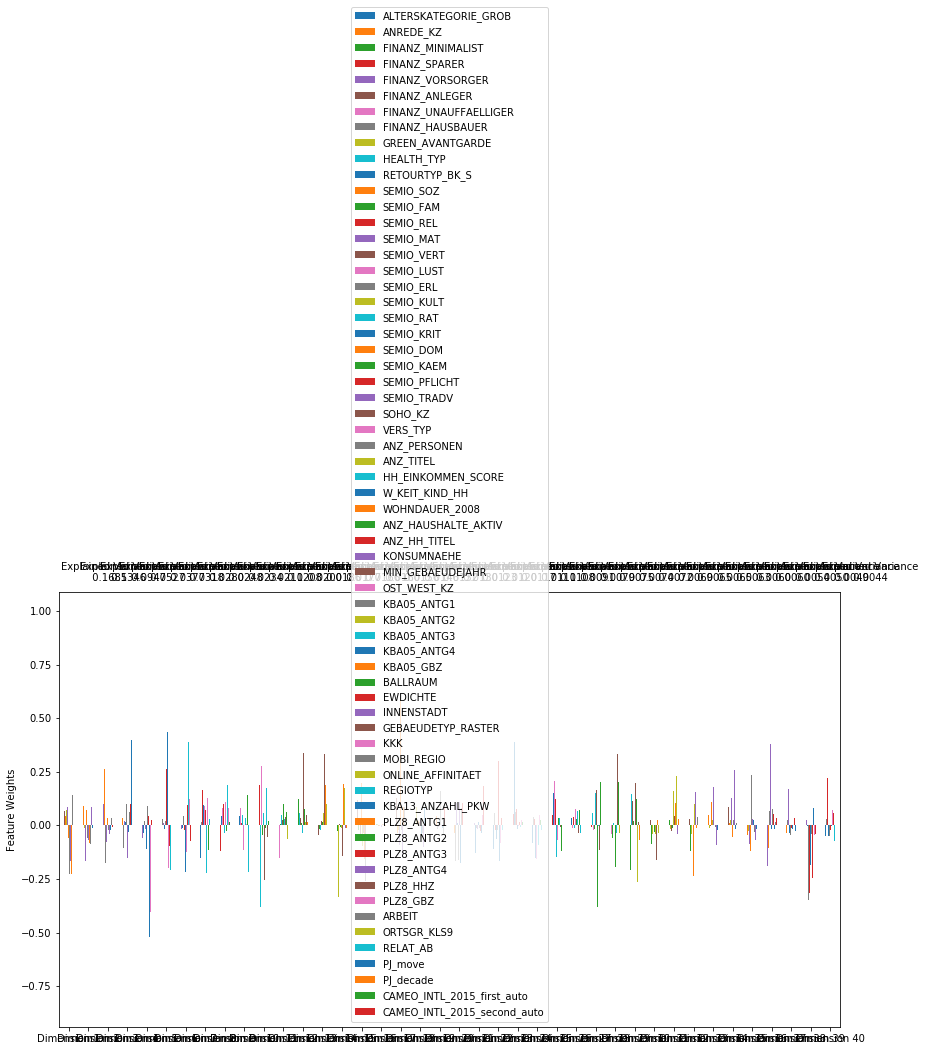

In [436]:
pca_results(data_scaled, pca)

In [437]:
def pca_weights(full_dataset, pca, comp):
    '''
    Print the sorted list of feature weights, for the i-th principal component
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # PCA results as dataframe
    results = pd.concat([variance_ratios, components], axis = 1)
    results = results.drop('Explained Variance', axis = 1)
    results = results.transpose()
    
    # single out desired i-th principal component
    key = 'Dimension '+str(comp)
    result = pd.DataFrame(results[key].sort_values(ascending=False))

    # Return a concatenated DataFrame
    return result

In [438]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp = 1
result = pca_weights(data_scaled, pca, comp)
print(result.head())
print(result.tail())

                            Dimension 1
PLZ8_ANTG3                       0.2275
PLZ8_ANTG4                       0.2206
CAMEO_INTL_2015_first_auto       0.2081
HH_EINKOMMEN_SCORE               0.2045
ORTSGR_KLS9                      0.1982
                   Dimension 1
KBA05_GBZ              -0.2179
FINANZ_MINIMALIST      -0.2184
KBA05_ANTG1            -0.2264
PLZ8_ANTG1             -0.2271
MOBI_REGIO             -0.2429


In [439]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 1
result = pca_weights(data_scaled, pca26, comp)
print(result.head())
print(result.tail())

                            Dimension 1
PLZ8_ANTG3                       0.2275
PLZ8_ANTG4                       0.2206
CAMEO_INTL_2015_first_auto       0.2081
HH_EINKOMMEN_SCORE               0.2045
ORTSGR_KLS9                      0.1982
                   Dimension 1
KBA05_GBZ              -0.2179
FINANZ_MINIMALIST      -0.2184
KBA05_ANTG1            -0.2264
PLZ8_ANTG1             -0.2271
MOBI_REGIO             -0.2429


In [440]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp = 2
result = pca_weights(data_scaled, pca, comp)
print(result.head())
print(result.tail())

                      Dimension 2
ALTERSKATEGORIE_GROB       0.2612
FINANZ_VORSORGER           0.2341
SEMIO_ERL                  0.2310
SEMIO_LUST                 0.1840
RETOURTYP_BK_S             0.1640
               Dimension 2
SEMIO_PFLICHT      -0.2292
SEMIO_TRADV        -0.2322
FINANZ_SPARER      -0.2372
PJ_decade          -0.2523
SEMIO_REL          -0.2557


In [441]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 2
result = pca_weights(data_scaled, pca26, comp)
print(result.head())
print(result.tail())

                      Dimension 2
ALTERSKATEGORIE_GROB       0.2612
FINANZ_VORSORGER           0.2341
SEMIO_ERL                  0.2310
SEMIO_LUST                 0.1840
RETOURTYP_BK_S             0.1640
               Dimension 2
SEMIO_PFLICHT      -0.2292
SEMIO_TRADV        -0.2322
FINANZ_SPARER      -0.2372
PJ_decade          -0.2523
SEMIO_REL          -0.2557


In [442]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp = 3
result = pca_weights(data_scaled, pca, comp)
print(result.head())
print(result.tail())

                   Dimension 3
SEMIO_VERT              0.3456
SEMIO_SOZ               0.2629
SEMIO_FAM               0.2503
SEMIO_KULT              0.2353
FINANZ_MINIMALIST       0.1559
            Dimension 3
SEMIO_RAT       -0.2174
SEMIO_KRIT      -0.2755
SEMIO_DOM       -0.3142
SEMIO_KAEM      -0.3373
ANREDE_KZ       -0.3689


In [443]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 3
result = pca_weights(data_scaled, pca26, comp)
print(result.head())
print(result.tail())

                   Dimension 3
SEMIO_VERT              0.3456
SEMIO_SOZ               0.2629
SEMIO_FAM               0.2503
SEMIO_KULT              0.2353
FINANZ_MINIMALIST       0.1559
            Dimension 3
SEMIO_RAT       -0.2174
SEMIO_KRIT      -0.2755
SEMIO_DOM       -0.3142
SEMIO_KAEM      -0.3373
ANREDE_KZ       -0.3689


### Discussion 2.3: Interpret Principal Components

Results are identical for 26 and 40 components. Of course, system with just 26 features provides numerical advantages.

Based on the PCA analysis, one can make the following observations:

The first component is strongly tied to the group of PLZ8 features that describe macro-cell features. It depends positively on PLZ8_ANTG3 and PLZ8_ANTG4 (i.e., the number of large family houses in the PLZ8 region) and is negatively correlated with PLZ8_ANTG1 (which refers to small family houses). Intuitively, this negative correlation between LARGE family houses (PLZ8_ANTG3, PLZ8_ANTG4) and small family houses (PLZ8_ANTG1) makes sense.

The second component depends on the age and some specific personality characteristic. It captures positively sensual-minded (SEMIO_LUST), event-oriented (SEMIO_ERL) people, as negatively opposed to the religious characteristics (SEMIO_REL). It also depends on the financial type of individual, positively with FINANZ_VORSORGER and negatively with FINANZ_SPARER. It strongly captures age, as specified by ALTERSKATEGORIE_GROB (the larger the older) and PJ_decade (the larger the younger) with opposite signs in agrrement with the opposite definitions for age.

The third component is strongly tied to the personality characteristics as described by the the group of SEMIO features. It uncovers positive and negative correlations between the personality traits. Namely, it is posititvely weighted with dreamful (VERT), socially-minded (SOZ), and family-minded (FAM) people, but negatively with combative (KAEM), dominant-minded (DOM), and crtitcal-minded people. These two types of characteristics paint an intuitive picture of two opposing types of personalities.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [444]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
    
    # compute the average within-cluster distances.

In [150]:
from sklearn.cluster import KMeans
import time

start = time.clock()
scores=[]
centers=[]

for kk in range(1,15):
    # Try instantiating a model with k centers
    kmeans = KMeans(kk)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(X_pca)

    # Obtain a score related to the model fit
    # lecture: sklearn score is an indication of how far the points are from the centroids
    labels = model.score(X_pca)
    
    centers.append(kk)
    scores.append(abs(labels))

elapsed = (time.clock() - start)

In [151]:
print (centers)
print (scores)
print (elapsed)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[47587687.974835306, 41159687.93327643, 37900912.84183909, 35816102.026078641, 34350874.818171069, 33101059.140961181, 31974519.457080368, 31115810.345364213, 30524230.571206622, 29951125.417944781, 29419031.462407522, 29125130.731358822, 28721772.973094054, 27950559.828384012]
1887.779254


In [152]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

Text(0.5,1,'SSE score')

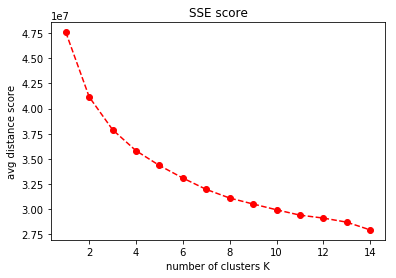

In [153]:
plt.plot(centers, scores,linestyle='--', marker='o', color='r')
plt.xlabel('number of clusters K')
plt.ylabel('avg distance score')
plt.title('SSE score')

In [154]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

In [445]:
from sklearn.cluster import KMeans

# Instantiate model with k=5 centers
kk = 5
kmeans = KMeans(kk)

# Fit the model to your data using the fit method
model = kmeans.fit(X_pca)

# Predict the labels (closest cluster) on the same data to show the category that every point belongs to
labels = model.predict(X_pca)

In [455]:
labels_out = model.predict(X_out_pca)

In [447]:
df_labels = pd.DataFrame(data=labels, columns=['Cluster'])
df_labels.head()

,Cluster
0,2
1,4
2,4
3,3
4,0


In [448]:
df_labels['Cluster'].unique()

array([2, 4, 3, 0, 1])

In [449]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels[df_labels['Cluster']==cc]
    percent = len(s)/len(df_labels)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 18.37%
Relative size of cluster number 1 in %: 22.27%
Relative size of cluster number 2 in %: 19.54%
Relative size of cluster number 3 in %: 20.31%
Relative size of cluster number 4 in %: 19.52%


In [457]:
df_labels_out = pd.DataFrame(data=labels_out, columns=['Cluster'])
df_labels_out.head()

,Cluster
0,0
1,0
2,0
3,0
4,0


In [458]:
df_labels_out['Cluster'].unique()

array([0, 3, 4, 2, 1])

In [459]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels_out[df_labels_out['Cluster']==cc]
    percent = len(s)/len(df_labels_out)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 83.86%
Relative size of cluster number 1 in %: 0.15%
Relative size of cluster number 2 in %: 0.63%
Relative size of cluster number 3 in %: 7.37%
Relative size of cluster number 4 in %: 7.98%


### Discussion 3.1: Apply Clustering to General Population

Trying to strike the balance between precision and simplicity, I choose k=5 clusters. This result is based on the analysis and plot given above showing that the SSE score drops significantly till k=5, but then starts to flatten out.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [460]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [461]:
customers.shape

(191652, 85)

In [272]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [462]:
# apply preprocessing
customers = clean_data(customers)

In [463]:
customers.shape

(140898, 64)

In [464]:
# apply transformations to customer data
customers = imputer.transform(customers)
customers = scaler.transform(customers)

# apply PCA
customers_pca = pca.transform(customers)

In [465]:
# get cluster assignments for customer data
labels_customers = model.predict(customers_pca)

In [466]:
df_labels_customers = pd.DataFrame(data=labels_customers, columns=['Cluster'])
df_labels_customers.head()

,Cluster
0,3
1,4
2,3
3,2
4,3


In [467]:
# repeat for customer outliers (high NaN ratio)
customers2 = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_out = get_outlier_data(customers2)
# apply transformations to customer data
customers_out = imputer.transform(customers_out)
customers_out = scaler.transform(customers_out)
# apply PCA
customers_out_pca = pca.transform(customers_out)
# get cluster assignments for customer data
labels_customers_out = model.predict(customers_out_pca)

df_labels_customers_out = pd.DataFrame(data=labels_customers_out, columns=['Cluster'])
df_labels_customers_out.head()

,Cluster
0,3
1,4
2,0
3,0
4,0


In [468]:
print('Shape of original data: ', customers2.shape)
print('Shape of trimmed, clean data (low NaN rows): ', customers.shape)
print('Shape of trimmed, clean data (high NaN rows: Outliers): ', customers_out.shape)

Shape of original data:  (191652, 85)
Shape of trimmed, clean data (low NaN rows):  (140898, 64)
Shape of trimmed, clean data (high NaN rows: Outliers):  (50754, 64)


In [469]:
#check if low-nan dataset and outlier dataset combine together to the full dataset
print('Shape of two data sets correct: ', customers2.shape[0] == (customers_out.shape[0]+customers.shape[0]))

Shape of two data sets correct:  True


In [470]:
percent = 100*(data_out_scaled.shape[0]/(data_out_scaled.shape[0]+azdias_drop_drop.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 11.10%


In [471]:
percent = 100*(customers_out.shape[0]/(customers_out.shape[0]+customers.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 26.48%


In [472]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels_customers_out[df_labels_customers_out['Cluster']==cc]
    percent = len(s)/len(df_labels_customers_out)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 92.43%
Relative size of cluster number 1 in %: 0.10%
Relative size of cluster number 2 in %: 0.05%
Relative size of cluster number 3 in %: 4.75%
Relative size of cluster number 4 in %: 2.67%


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [473]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [474]:
def get_cluster_relative_cluster_size(data, k):
    for cc in range(0,k):
        s = data[data['Cluster']==cc]
        percent = len(s)/len(data)*100
        print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

In [475]:
# distribution in general demographic data
get_cluster_relative_cluster_size(df_labels,5)

Relative size of cluster number 0 in %: 18.37%
Relative size of cluster number 1 in %: 22.27%
Relative size of cluster number 2 in %: 19.54%
Relative size of cluster number 3 in %: 20.31%
Relative size of cluster number 4 in %: 19.52%


In [476]:
# distribution in customer data
get_cluster_relative_cluster_size(df_labels_customers,5)

Relative size of cluster number 0 in %: 3.23%
Relative size of cluster number 1 in %: 17.99%
Relative size of cluster number 2 in %: 2.13%
Relative size of cluster number 3 in %: 55.23%
Relative size of cluster number 4 in %: 21.42%


In [477]:
def get_cluster_relative_cluster_size2(data, k):
    cluster_number=[]
    cluster_size=[]
    for cc in range(0,k):
        s = data[data['Cluster']==cc]
        percent = len(s)/len(data)*100
        print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))
        cluster_size.append(percent)
        cluster_number.append(cc)
    
    result = pd.DataFrame(cluster_size, index=cluster_number)
    result.columns = ['size']

    return result

In [478]:
# distribution in general demographic data
result_population = get_cluster_relative_cluster_size2(df_labels,5)

Relative size of cluster number 0 in %: 18.37%
Relative size of cluster number 1 in %: 22.27%
Relative size of cluster number 2 in %: 19.54%
Relative size of cluster number 3 in %: 20.31%
Relative size of cluster number 4 in %: 19.52%


In [479]:
# distribution in general demographic data
result_customer = get_cluster_relative_cluster_size2(df_labels_customers,5)

Relative size of cluster number 0 in %: 3.23%
Relative size of cluster number 1 in %: 17.99%
Relative size of cluster number 2 in %: 2.13%
Relative size of cluster number 3 in %: 55.23%
Relative size of cluster number 4 in %: 21.42%


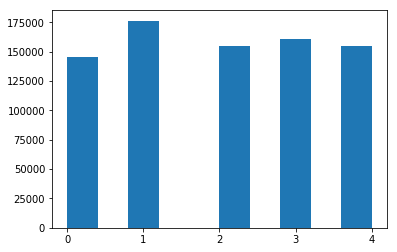

In [480]:
# plot histogram of general population
plt.hist(df_labels)
plt.show()

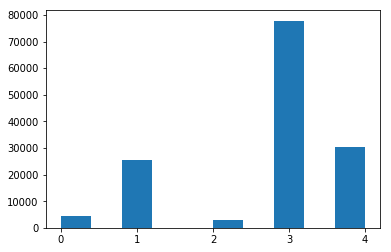

In [481]:
# plot histogram of customers
plt.hist(df_labels_customers)
plt.show()

In [482]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [483]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [484]:
cluster_centers = pd.DataFrame(model.cluster_centers_)
cluster_centers_orig = pd.DataFrame(pca.inverse_transform(model.cluster_centers_), columns=azdias_drop_drop.keys())

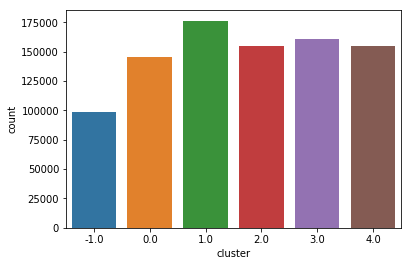

In [485]:
# Distribution of general population
# distribution is relatively homogeneous (up to slighlty smaller outlier cluster)
labels1=pd.DataFrame(labels)
labels1.columns=['cluster']

# cluster -1 includes those rows having too many NaNs (larger than threshold)
labels2=pd.DataFrame(-1*np.ones([labels_out.shape[0],1]))
labels2.columns=['cluster']

labels=pd.concat([labels1,labels2],axis=0)

import seaborn as sns
sns.countplot(x='cluster', data=labels)

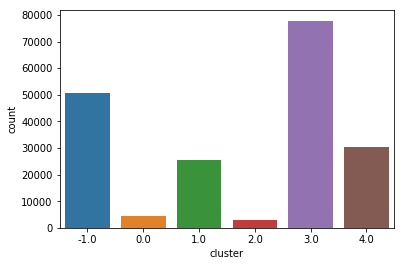

In [486]:
# Distribution of customer population
# outlier segment (lots of NaNs) makes up second largest fraction among customer data 
labels1=pd.DataFrame(labels_customers)
labels1.columns=['cluster']

# cluster -1 includes those rows having too many NaNs (larger than threshold)
labels2=pd.DataFrame(-1*np.ones([labels_customers_out.shape[0],1]))
labels2.columns=['cluster']

labels=pd.concat([labels1,labels2],axis=0)

import seaborn as sns
sns.countplot( x='cluster', data=labels)

In [487]:
percent = 100*(data_out.shape[0]/(data_out.shape[0]+azdias_drop_drop.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 11.10%


In [488]:
percent = 100*(customers_out.shape[0]/(customers_out.shape[0]+customers.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 26.48%


### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 3 is strongly overrepresented as compared to the geenral population which is fairly homogeneous across the different clusters. It makes up about 55% in the customer population, but only 20% in the general population. Therefore, Cluster 3 should be our target cluster. The centroid of cluster 3 lies in the positive region of the first PCA, at the origin (zero) of the second PCA feature and in the negative region of the third PCA. Therefore, the target audience seems to live in areas with relatively large family houses (as described by the first PCA variable) and shows personality characteristics that can be read off from PCA3 (which depends mostly on the original SEMIO features).


Conversely, clusters 1 and 4 are stronlgy underrepresented. They only make up 2% and 3% of the customer population, while accounting for about 20% each in the general population. The centroid of cluster 4 lies at the origin of PCA1 and PCA3, but shows a strong negative number on PCA2. Accordingly, cluster 4 refers to a group of relatively young people that should not be targeted primarily as customers.


Rows with a large fraction of NaN values (referred to as outliers above) have been introduced as seprate cluster. This cluster has been found to make up a much larger portion of the population within our customers (26%) as compared to the general population where it accounts for about 11% only.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.